## Solution of a Driven Damped Pendulum using a Kolmogorov-Arnold Network (KAN)

***Author: Brandon Ismalej (brandon.ismalej.671@my.csun.edu) - (https://github.com/Brandon-Ism)***

In [1]:
!pip install pykan torch numpy matplotlib scikit-learn tqdm sympy setuptools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 2.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
from torch import autograd
from kan import KAN
import math
import os

In [3]:
from sympy import symbols, Function
gamma_sym = symbols('gamma')
gamma_func = Function('gamma')

# Clear previous definitions
del gamma_sym
del gamma_func

In [4]:
# Initialize Constants
Omega_val = 2 * np.pi  
omega_val = Omega_val * 1.5 
lambda_val = omega_val / 2 
gamma_val = 0.8
omegaSQ_val = omega_val ** 2
f_val = gamma_val * omegaSQ_val

In [5]:
# This is the function for scipy odeint that helps it to solve the diff equation
# Differential equation
def helper(t, theta):
    theta, z = theta
    dthetadt = [z, f_val * math.cos(Omega_val * t) - omegaSQ_val * math.sin(theta) - lambda_val * z]
    return dthetadt

In [6]:
# Define the driven damped pendulum differential equation
#def driven_damped_pendulum(t, y, omega, lambda_, gamma, Omega):
#    theta, omega_dot = y
#   dydt = [omega_dot, -lambda_ * omega_dot - omega**2 * np.sin(theta) + gamma * np.cos(Omega * t)]
 #   return dydt


    
# Initial conditions
y0 = [0, 0]
start_val = 0
end_val = 15

initial_conditions = [0, 0]

# Time points
t = np.linspace(start_val, end_val, 15000)


sol = solve_ivp(helper, [start_val, end_val], initial_conditions, t_eval=t, method='LSODA', rtol=1e-6, atol=1e-8)    

# Solve the differential equation using solve_ivp
# sol = solve_ivp(driven_damped_pendulum, [t[0], t[-1]], y0, args=(omega_val, lambda_val, gamma_val, Omega_val), t_eval=t, method='LSODA', rtol=1e-6, atol=1e-8)

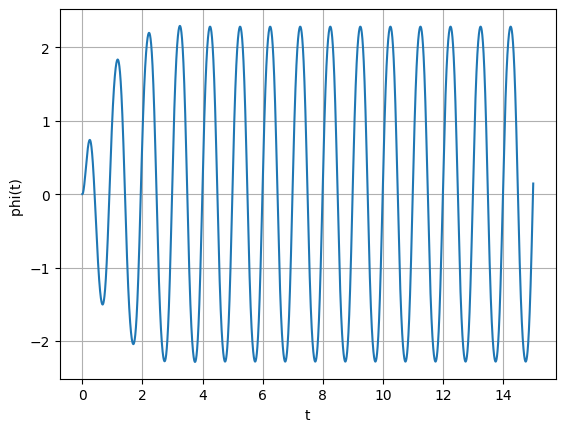

In [7]:
plt.plot(sol.t, sol.y[0], label='Numerical Solution')

plt.xlabel('t')
plt.ylabel('phi(t) ')
plt.grid(True)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [8]:
# Save ODE solver results to CSV
ode_df = pd.DataFrame({'t': sol.t, 'theta': sol.y[0], 'omega_dot': sol.y[1]})
ode_df.to_csv('ode_solver_results.csv', index=False)

In [9]:
# Generate training data
x = torch.tensor(t, dtype=torch.float32).view(-1, 1)
y = torch.tensor(sol.y[0], dtype=torch.float32).view(-1, 1)
x_physics = torch.linspace(0, 5, 15000).view(-1,1).requires_grad_(True) # sample locations over the problem domain
x_boundary = torch.tensor([[0.0]]).requires_grad_(True)

In [10]:
print({type(x_physics)})

{<class 'torch.Tensor'>}


In [11]:
from kan import *
# Define the KAN model
physics_weight = 1e-3
model = KAN(width=[1,15,10,15,1], grid=5, k=3, seed=0)
#model = KAN(width=[1,10,1], grid=5, k=3, grid_eps=1.0) #noise scale base error after pykan updates
model.update_grid_from_samples(x_physics)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

checkpoint directory created: ./model
saving model version 0.0


In [12]:
# Convert to torch.Tensor
Omega = torch.tensor(Omega_val, dtype=torch.float32)
omega = torch.tensor(omega_val, dtype=torch.float32)
lambda_ = torch.tensor(lambda_val, dtype=torch.float32)
gamma = torch.tensor(gamma_val, dtype=torch.float32)  
omegaSQ = torch.tensor(omegaSQ_val, dtype=torch.float32)
f = torch.tensor(f_val, dtype=torch.float32)

In [13]:
# Training loop

epochs = 5000
losses = {'boundaryloss': [], 'physicsloss': [], 'totalloss': []}

for i in range(epochs):
    optimizer.zero_grad()
    
    # Compute the "physics loss"
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0] # computes dy/dx
    dx2 = torch.autograd.grad(dx, x_physics, torch.ones_like(dx), create_graph=True)[0]  # computes d^2y/dx^2
    physics = dx2 - omegaSQ * torch.sin(yhp) - lambda_ * dx + f * torch.cos(Omega * x_physics)  # residual of the helper differential equation
    physicsloss = physics_weight * torch.mean(physics**2)

    
    # Compute the "boundary loss"
    y_boundary = model(x_boundary)
    dx_boundary = torch.autograd.grad(y_boundary, x_boundary, torch.ones_like(y_boundary), create_graph=True)[0]
    boundaryloss = torch.squeeze((y_boundary - 0.0)**2 + dx_boundary**2)
    
    # Combine losses
    loss = boundaryloss + physicsloss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update parameters
    
    # Store losses
    losses['boundaryloss'].append(boundaryloss.detach().item())
    losses['physicsloss'].append(physicsloss.detach().item())
    losses['totalloss'].append(loss.detach().item())

    if (i+1) % 100 == 0:
        print(f'Epoch [{i+1}/{epochs}], Total Loss: {loss.item():.4f}')

Epoch [100/5000], Total Loss: 0.1101
Epoch [200/5000], Total Loss: 0.1011
Epoch [300/5000], Total Loss: 0.1005
Epoch [400/5000], Total Loss: 0.0999
Epoch [500/5000], Total Loss: 0.0997
Epoch [600/5000], Total Loss: 0.0998
Epoch [700/5000], Total Loss: 0.0998
Epoch [800/5000], Total Loss: 0.0994
Epoch [900/5000], Total Loss: 0.1005
Epoch [1000/5000], Total Loss: 0.1003
Epoch [1100/5000], Total Loss: 0.0996
Epoch [1200/5000], Total Loss: 0.1006
Epoch [1300/5000], Total Loss: 0.1015
Epoch [1400/5000], Total Loss: 0.1047
Epoch [1500/5000], Total Loss: 0.1017
Epoch [1600/5000], Total Loss: 0.0994
Epoch [1700/5000], Total Loss: 0.1005
Epoch [1800/5000], Total Loss: 0.1102
Epoch [1900/5000], Total Loss: 0.0990
Epoch [2000/5000], Total Loss: 0.0990
Epoch [2100/5000], Total Loss: 0.1000
Epoch [2200/5000], Total Loss: 0.0995
Epoch [2300/5000], Total Loss: 0.0990
Epoch [2400/5000], Total Loss: 0.0998
Epoch [2500/5000], Total Loss: 0.0990
Epoch [2600/5000], Total Loss: 0.0990
Epoch [2700/5000], To

In [14]:
# Print final losses
print("\nFinal Losses:")
print(f"Boundary Loss: {losses['boundaryloss'][-1]:.4f}")
print(f"Physics Loss: {losses['physicsloss'][-1]:.4f}")
print(f"Total Loss: {losses['totalloss'][-1]:.4f}")


Final Losses:
Boundary Loss: 0.0180
Physics Loss: 0.0823
Total Loss: 0.1003


In [15]:
# Save KAN loss values to CSV
loss_df = pd.DataFrame(losses)
loss_df.to_csv('kan_loss_values.csv', index=False)

In [16]:
# Predict using the KAN model
x_test = torch.tensor(t, dtype=torch.float32).view(-1, 1)
y_kan = model(x_test).detach().numpy()

In [17]:
# Save KAN results to CSV
kan_df = pd.DataFrame({'t': t, 'theta': y_kan.squeeze()})
kan_df.to_csv('kan_results.csv', index=False)

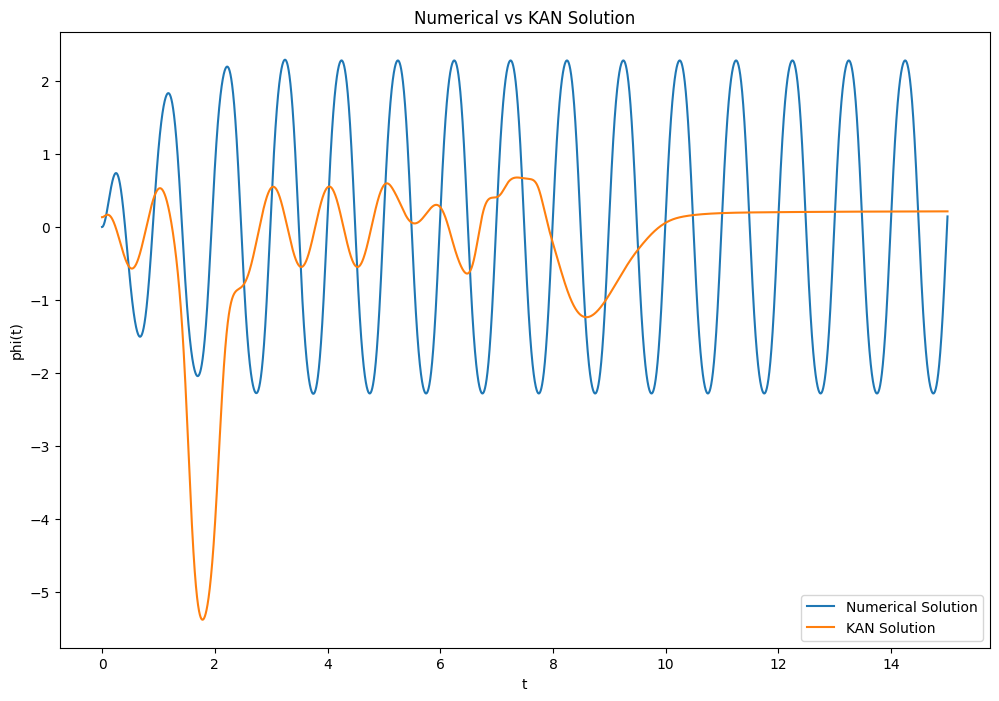

In [18]:
# Plot both the numerical and KAN solutions 
plt.figure(figsize=(12, 8))  
plt.plot(sol.t, sol.y[0], label='Numerical Solution')
plt.plot(t, y_kan, label='KAN Solution')
plt.xlabel('t')
plt.ylabel('phi(t)')
plt.legend()
plt.title('Numerical vs KAN Solution')


plt.savefig('/kaggle/working/KAN_vs_numerical.png')
plt.show()

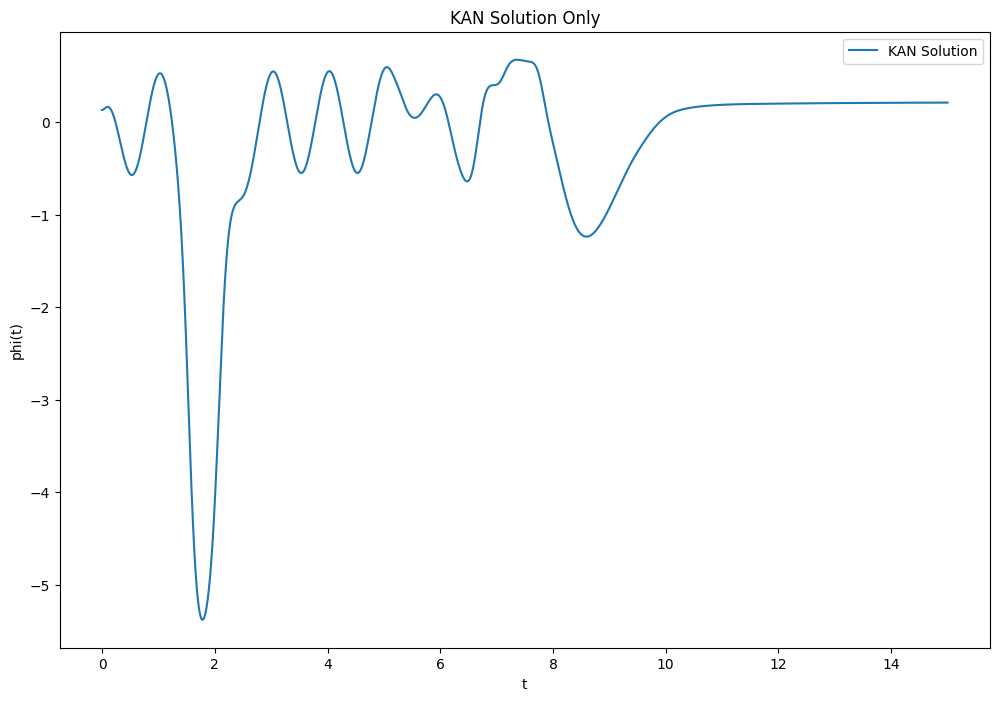

In [19]:
# Plot only the KAN solution
plt.figure(figsize=(12, 8))
plt.plot(t, y_kan, label='KAN Solution')
plt.xlabel('t')
plt.ylabel('phi(t)')
plt.legend()
plt.title('KAN Solution Only')

plt.savefig('/kaggle/working/KAN_only.png')
plt.show()

In [20]:
# Plot the KAN grid

#model.plot()

In [21]:
# Try time up to 20
#